# ML Training Notebook for Cultivated

Notebook to train ML model to discriminate between cultivated and natural vegetation. Text file with extracted data can be downloaded from: Model is trained using data extracted to a CSV file.

The version with all pixels can be downloaded from: https://rsg.pml.ac.uk/shared_files/dac/train_input_geomedian_tmad.txt.gz

As geomedian and mads are calculated separatly need to combine to a single file using:
```python
import numpy
input_data = numpy.loadtxt("geomedian_stats_2015.txt", skiprows=1)
input_data_mads = numpy.loadtxt("tmad_stats_2015.txt", skiprows=1)

combined_data = numpy.hstack((input_data, input_data_mads[:,1:]))

column_names = 'classnum blue green red nir swir1 swir2 BUI BSI NBI EVI NDWI MSAVI sdev edev bcdev'

numpy.savetxt("training_data_2015_geomedian_mads_poly_mean",
              combined_data,             
              header=column_names, comments='', fmt='%.4f')
```

A version using the mean value for each feature is in the same repo as this notebook.

In [1]:
import os
import pickle
import numpy
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Set up working dir
working_dir = '/home/jovyan/cultivated_classification'

In [3]:
# Read in text file
# As it takes a while first see if there is a pickled version from a previous run
# pickled_model_input = os.path.join(working_dir, 'training_data_2015_geomedian_mads_poly_mean_numpy.npy')

# if os.path.isfile(pickled_model_input):
#     print('Loading pickled model input file')
#     model_input = numpy.load(pickled_model_input)
# else:
#     print('Reading model input from text file...')
#     model_input = numpy.loadtxt(os.path.join(working_dir, 'training_data_2015_geomedian_mads_poly_mean.txt'), skiprows=1)
#     numpy.save(pickled_model_input, model_input)

model_input = numpy.loadtxt(os.path.join(working_dir, 'training_data_2015_geomedian_mads_poly_mean.txt'), skiprows=1)
  
    
# Headers are
# classnum blue green red nir swir1 swir2 BUI BSI NBI EVI NDWI MSAVI sdev edev bcdev
column_names = 'classnum blue green red nir swir1 swir2 BUI BSI NBI EVI NDWI MSAVI sdev edev bcdev'.split()

column_names_indices = {}

for col_num, var_name in enumerate(column_names):
    column_names_indices[var_name] = col_num

In [9]:
from sklearn import preprocessing

In [18]:
# Split into training and testing data
# Use class to provide similar distribution across classes
# in training and testing data
model_train, model_test = model_selection.train_test_split(model_input, stratify=model_input[:,0],
                                                           train_size=0.8, random_state=0)

x_train = preprocessing.scale(model_train[:,model_col_indices])
x_test = preprocessing.scale(model_test[:,model_col_indices])

y_train = model_train[:,0]
y_test = model_test[:,0]

In [20]:
model_variables = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'sdev', 'edev']

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="rbf", C=0.025, probability=True),
#     NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = precision_recall_fscore_support(y_test, train_predictions)
    print(acc[0])
    #     print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
(array([0.9398374 , 0.93796526, 0.88888889, 0.93636364, 0.96103896]), array([0.9681742 , 0.945     , 0.6       , 0.86554622, 0.97368421]), array([0.95379538, 0.94146949, 0.71641791, 0.89956332, 0.96732026]), array([597, 400,  40, 119,  76]))
Log Loss: 0.48727671149157553
SVC
****Results****
(array([0.80774963, 0.78444444, 0.        , 0.9122807 , 0.90740741]), array([0.9078727 , 0.8825    , 0.        , 0.43697479, 0.64473684]), array([0.85488959, 0.83058824, 0.        , 0.59090909, 0.75384615]), array([597, 400,  40, 119,  76]))
Log Loss: 0.41558335593361867
DecisionTreeClassifier
****Results****
(array([0.9089404 , 0.89460784, 0.51282051, 0.9009901 , 0.8875    ]), array([0.91959799, 0.9125    , 0.5       , 0.76470588, 0.93421053]), array([0.91423813, 0.90346535, 0.50632911, 0.82727273, 0.91025641]), array([597, 400,  40, 119,  76]))
Log Loss: 3.8127220695680677
RandomForestClassifier
****Results****
(array([0.94754098, 0.9408867 , 0.89285714, 0.9629

In [39]:
acc

(array([0.93227092, 0.83448276, 0.375     , 0.76515152, 0.91566265]),
 array([0.7839196, 0.9075   , 0.75     , 0.8487395, 1.       ]),
 array([0.85168335, 0.86946108, 0.5       , 0.80478088, 0.95597484]),
 array([597, 400,  40, 119,  76]))

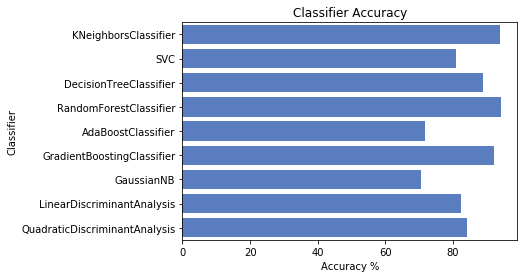

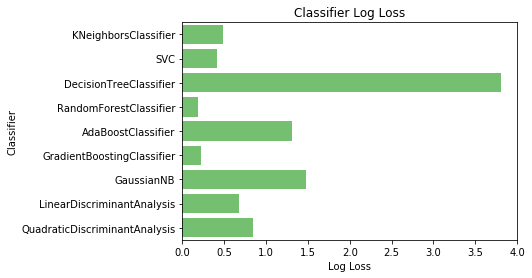

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# Old stuff

In [77]:
# Set up model

# model = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=0, oob_score=True)

# Hyper parameters chosen by Grid Search CV
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

model_variables = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'sdev', 'edev']

model_col_indices = []

for model_var in model_variables:
    model_col_indices.append(column_names_indices[model_var])

In [78]:
# Train model
model.fit(model_train[:,model_col_indices], model_train[:,0])

In [79]:
# Test model using data held back for training
score = model.score(model_test[:,model_col_indices], model_test[:,0])
print("Accuracy: {:.03}".format(score))

Accuracy: 0.942


In [80]:
# Variable importance
for var_name, var_importance in zip(model_variables, model.feature_importances_):
    print("{}: {:.04}".format(var_name, var_importance))

red: 0.1099
blue: 0.1094
green: 0.1533
nir: 0.1146
swir1: 0.08998
swir2: 0.09796
sdev: 0.1091
edev: 0.2159


In [9]:
ml_model_dict = {}

ml_model_dict['variables'] = model_variables
ml_model_dict['classes'] = {'Not natural terrestrial vegetation' : 111,
                            'Natural terrestrial vegetation ' : 112}
ml_model_dict['classifier'] = model

# Pickle model
with open(os.path.join(working_dir, 'model_pickle.pickle'), 'wb') as f:
    pickle.dump(ml_model_dict, f)